In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy as scp
from datetime import datetime, timedelta
import copy

In [2]:
from flaskr.report import get_waterbody_collection
from flaskr.db import get_group_metrics, get_waterbody_data
import flaskr.utils as utils

color_mapping = {
    "no detection": '#3388ff',
    "low": '#008000',
    "medium": '#c8c800',
    "high": '#ffa500',
   "very high": '#ff0000'
}

ranges_dict = {"low": utils.DEFAULT_RANGE[0], "medium": utils.DEFAULT_RANGE[1], "high": utils.DEFAULT_RANGE[2], "very high": [utils.DEFAULT_RANGE[2][1], 254]}
ranges = [utils.DEFAULT_RANGE[0], utils.DEFAULT_RANGE[1], utils.DEFAULT_RANGE[2]] 

In [3]:
county = ['12093']
objectids = [6624886, 7561665, 862709, 115083, 476621]
year = 2021
day = 253
start_date = datetime(year=year, month=1, day=1) + timedelta(days=day - 1)
end_date = start_date - timedelta(days=30)
end_day = 214


In [4]:
# waterbodies, group_type = get_waterbody_collection(counties=county)
waterbodies, group_type = get_waterbody_collection(objectids=objectids)
waterbodies.values()

dict_values([[6624886, 7561665, 862709, 115083, 476621]])

In [5]:
# objectids = [int(id) for id in county]
wb_data = []
for oid in objectids:
    data = get_waterbody_data(objectid=str(oid), start_year=year, start_day=end_day, ranges=copy.copy(ranges), non_blooms=True)
    for datestr, values in data.items():
        date_split = datestr.split(" ")
        data_date = datetime(year=int(date_split[0]), month=1, day=1) + timedelta(days=int(date_split[1]) - 1)
        n = np.sum(values)
        n0 = np.sum(values[0:4])
        b = values[4]
        if n0 == 0 and b == 0:
            results = {"OBJECTID": str(oid),
                       "date": data_date,
                       "low": np.nan,
                       "medium": np.nan,
                       "high": np.nan,
                       "very high": np.nan,
                       "total cyan(low)": np.nan,
                       "total cyan(med)": np.nan,
                       "total cyan(high)": np.nan,
                       "below detection": round(values[4]/n, 4),
                       "land": round(values[5]/n, 4),
                       "no data": round(values[6]/n, 4),
                       "area": n
                      }
        else:
            results = {"OBJECTID": str(oid),
                       "date": data_date,
                       "low": round(values[0]/n, 4),
                       "medium": round(values[1]/n, 4),
                       "high": round(values[2]/n, 4),
                       "very high": round(values[3]/n, 4),
                       "total cyan(low)": round(np.sum(values[0:4])/n, 4),
                       "total cyan(med)": round(np.sum(values[1:4])/n, 4),
                       "total cyan(high)": round(np.sum(values[2:4])/n, 4),
                       "below detection": round(values[4]/n, 4),
                       "land": round(values[5]/n, 4),
                       "no data": round(values[6]/n, 4),
                       "area": n
                      }
        wb_data.append(results)
df = pd.DataFrame(wb_data)

In [6]:
# objectids = [int(id) for id in county]
wb_data = []
for oid in objectids:
    data = get_waterbody_data(objectid=str(oid), start_year=year, start_day=end_day, non_blooms=True)
    for datestr, values in data.items():
        date_split = datestr.split(" ")
        data_date = datetime(year=int(date_split[0]), month=1, day=1) + timedelta(days=int(date_split[1]) - 1)
        area = np.sum(values)
        
        low_sum = 0
        l_n = 0
        for i in range(1, ranges[0][1]):
            l_n += values[i]
            low_sum += i*values[i]
        low_avg = low_sum / l_n if l_n > 0 else np.nan
        
        med_sum = 0
        m_n = 0
        for i in range(ranges[1][0], ranges[1][1]):
            m_n += values[i]
            med_sum += i*values[i]
        med_avg = med_sum / m_n if m_n > 0 else np.nan
        
        high_sum = 0
        h_n = 0
        for i in range(ranges[2][0], ranges[2][1]):
            h_n += values[i]
            high_sum += i*values[i]
        high_avg = high_sum / h_n if h_n > 0 else np.nan
        
        vhigh_sum = 0
        vh_n = 0
        for i in range(ranges[2][1], 254):
            vh_n += values[i]
            vhigh_sum += i*values[i]
        vhigh_avg = vhigh_sum / vh_n if vh_n > 0 else np.nan
        
        results = {"OBJECTID": str(oid),
                   "date": data_date,
                   "low": np.sum(values[ranges[0][0]:ranges[0][1]]),
                   "low avg": low_avg,
                   "medium": np.sum(values[ranges[1][0]:ranges[1][1]]),
                   "medium avg": med_avg,
                   "high": np.sum(values[ranges[2][0]:ranges[2][1]]),
                   "high avg": high_avg,
                   "very high": np.sum(values[ranges[2][1]:254]),
                   "very high avg": vhigh_avg,
                   "below detection": values[0],
                   "land": values[254],
                   "no data": values[255],
                   "area": area,
                   "day": int(date_split[1])
                    }
        wb_data.append(results)
df2 = pd.DataFrame(wb_data)

In [7]:
df2.head()

OBJECTID       date     low    low avg  medium  medium avg    high  \
0  6624886 2021-08-02  1806.0  60.540421  1117.0  119.944494   950.0   
1  6624886 2021-08-03   308.0  68.964286   257.0  118.607004    89.0   
2  6624886 2021-08-04     0.0        NaN     0.0         NaN     0.0   
3  6624886 2021-08-05   888.0  58.912162   489.0  119.550102   459.0   
4  6624886 2021-08-06  2051.0  58.927840   941.0  119.413390  1186.0   

     high avg  very high  very high avg  below detection  land  no data  \
0  159.274737      153.0     193.366013           8416.0  68.0   2446.0   
1  154.089888        7.0     194.142857           3411.0  68.0  10816.0   
2         NaN        0.0            NaN            443.0  68.0  14445.0   
3  157.189542       16.0     187.437500           6588.0  68.0   6448.0   
4  161.158516      332.0     190.972892           8848.0  68.0   1530.0   

      area  day  
0  14956.0  214  
1  14956.0  215  
2  14956.0  216  
3  14956.0  217  
4  14956.0  218

In [8]:
# objectids = [int(id) for id in county]
wb_data = {}
for oid in objectids:
    data = get_waterbody_data(objectid=str(oid), start_year=year, start_day=end_day, non_blooms=True)
    results = []
    for datestr, values in data.items():
        date_split = datestr.split(" ")
        data_date = datetime(year=int(date_split[0]), month=1, day=1) + timedelta(days=int(date_split[1]) - 1)
        results.append([data_date, *values])
    wb_data[str(oid)] = results

In [9]:
import plotly.graph_objects as go

oi = 0
totals = ["total cyan(low)", "total cyan(med)", "total cyan(high)", "very high"]

In [92]:
oi_data = np.array(wb_data[str(objectids[oi])])
dates = oi_data[:,0]
x = np.arange(1, 254)
y = oi_data[:,2:255]
df = pd.DataFrame(data={"indx":x, "count":y[0]})
df.info()
# print(f"Dates: {len(dates)}, y: {len(y)}, z: {len(z)}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253 entries, 0 to 252
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   indx    253 non-null    int32 
 1   count   253 non-null    object
dtypes: int32(1), object(1)
memory usage: 3.1+ KB


In [100]:
i = 3
hist_fig = go.Figure([
    go.Scatter(x=x[ranges[0][0]:ranges[0][1]+1], y=y[i][ranges[0][0]:ranges[0][1]+1], marker_color=color_mapping["low"], name="Low"),
    go.Scatter(x=x[ranges[1][0]:ranges[1][1]+1], y=y[i][ranges[1][0]:ranges[1][1]+1], marker_color=color_mapping["medium"], name="Medium"),
    go.Scatter(x=x[ranges[2][0]:ranges[2][1]+1], y=y[i][ranges[2][0]:ranges[2][1]+1], marker_color=color_mapping["high"], name="High"),
    go.Scatter(x=x[ranges[2][1]:], y=y[i][ranges[2][1]:], marker_color=color_mapping["very high"], name="Very High")])
hist_fig.show()

In [113]:
date_i = 0
location = str(objectids[oi])

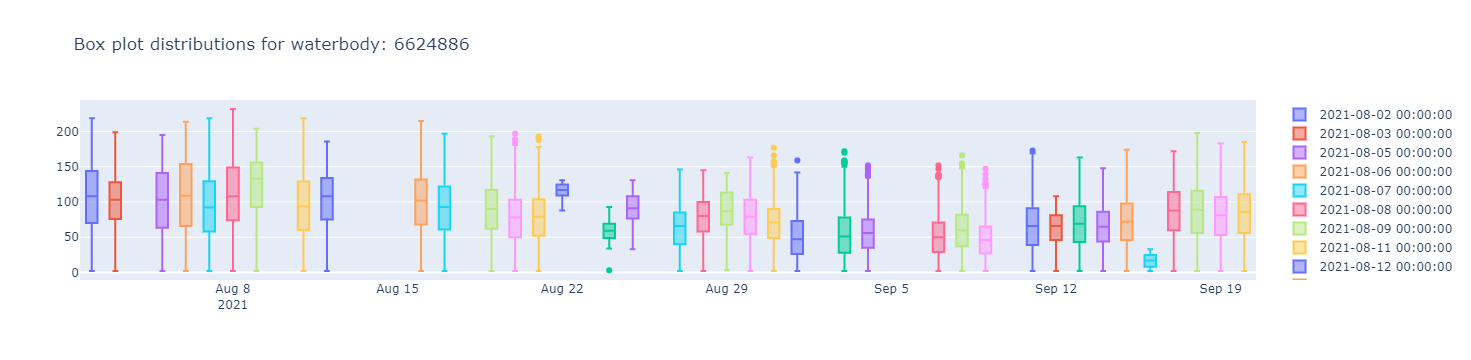

In [118]:
# Box plot for the location at oi
traces = []
for r in wb_data[location]:
    y_data = []
    for i in range(2, 255):
        r_v = []
        if r[i] > 0:
            r_v = [i]*int(r[i])
        y_data = [*y_data, *r_v]
    traces.append(go.Box(y=y_data, name=str(r[0])))
fig = go.Figure(data=traces)
fig.update_layout(title=f"Box plot distributions for waterbody: {location}")
fig.show()

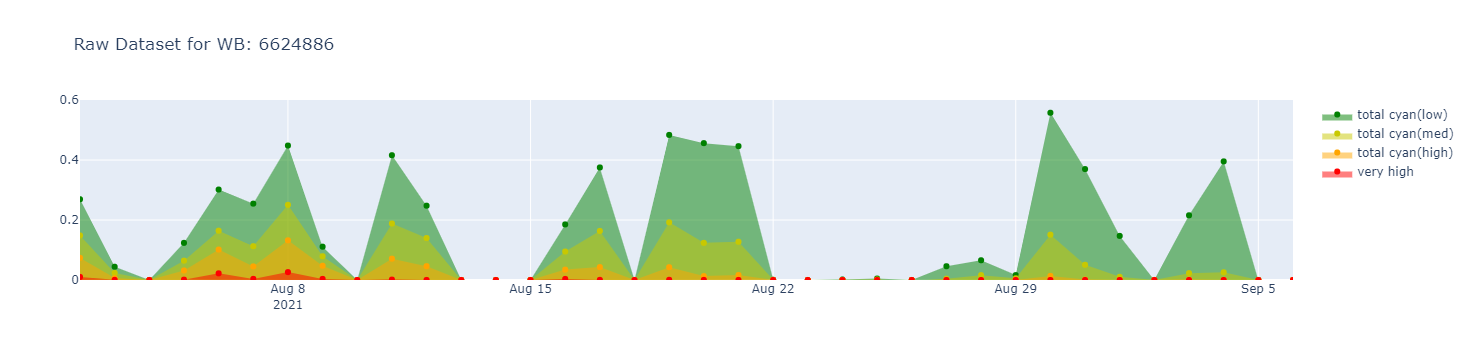

In [40]:
traces2 = []
j_data = df[df["OBJECTID"] == str(objectids[0])]
for indx, t in enumerate(totals):
    traces2.append(go.Scatter(x=j_data["date"], y=j_data[t], name=t, mode='markers', fill='tozeroy', marker_color=list(color_mapping.values())[indx+1]))
fig2 = go.Figure(data=traces2)
fig2.update_layout(title={'text':f'Raw Dataset for WB: {objectids[oi]}'})
fig2.show()

In [21]:
from plotly.subplots import make_subplots
import plotly.express as px
from flaskr.utils import convert_dn

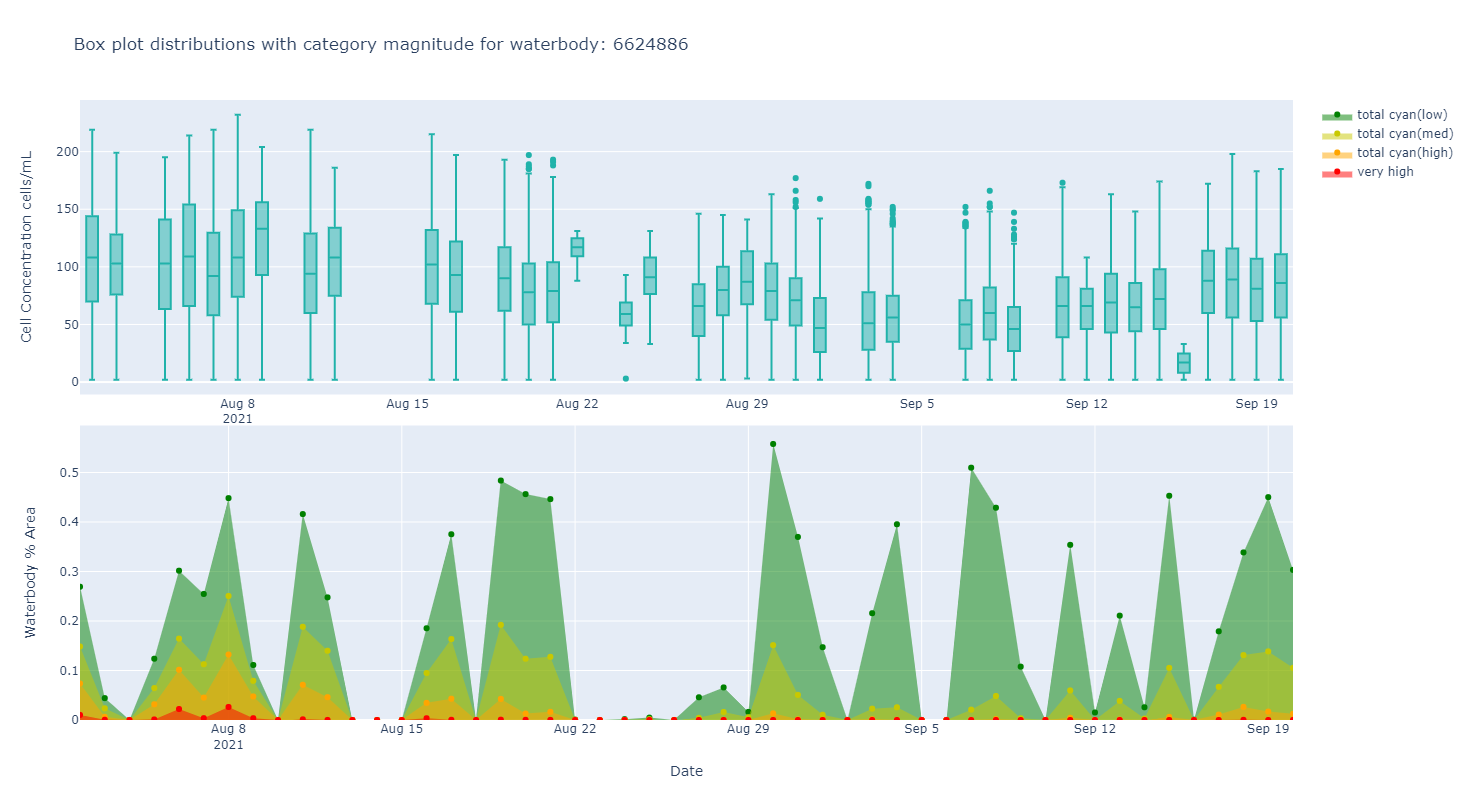

In [28]:
oi = 0
location = str(objectids[oi])
fig = make_subplots(
    rows=2, cols=1, 
#     shared_xaxes=True,
    vertical_spacing=0.05,
    specs=[[{"type": "box"}],
           [{"type": "bar"}]
          ])

for r in wb_data[location]:
    y_data = []
    for i in range(2, 255):
        r_v = []
        if r[i] > 0:
            r_v = [i]*int(r[i])
        y_data = [*y_data, *r_v]
    fig.add_trace(go.Box(y=y_data, name=str(r[0]), showlegend=False, marker_color='lightseagreen'), row=1, col=1)
j_data = df[df["OBJECTID"] == location]
for indx, t in enumerate(totals):
    fig.add_trace(go.Scatter(x=j_data["date"], y=j_data[t], name=t, mode='markers', fill='tozeroy', marker_color=list(color_mapping.values())[indx+1]), row=2, col=1)
fig.update_layout(title=f"Box plot distributions with category magnitude for waterbody: {location}", height=800)
fig['layout']['xaxis2']['title']='Date'
fig['layout']['yaxis']['title']='Cell Concentration cells/mL'
fig['layout']['yaxis2']['title']='Waterbody % Area'
fig.show()


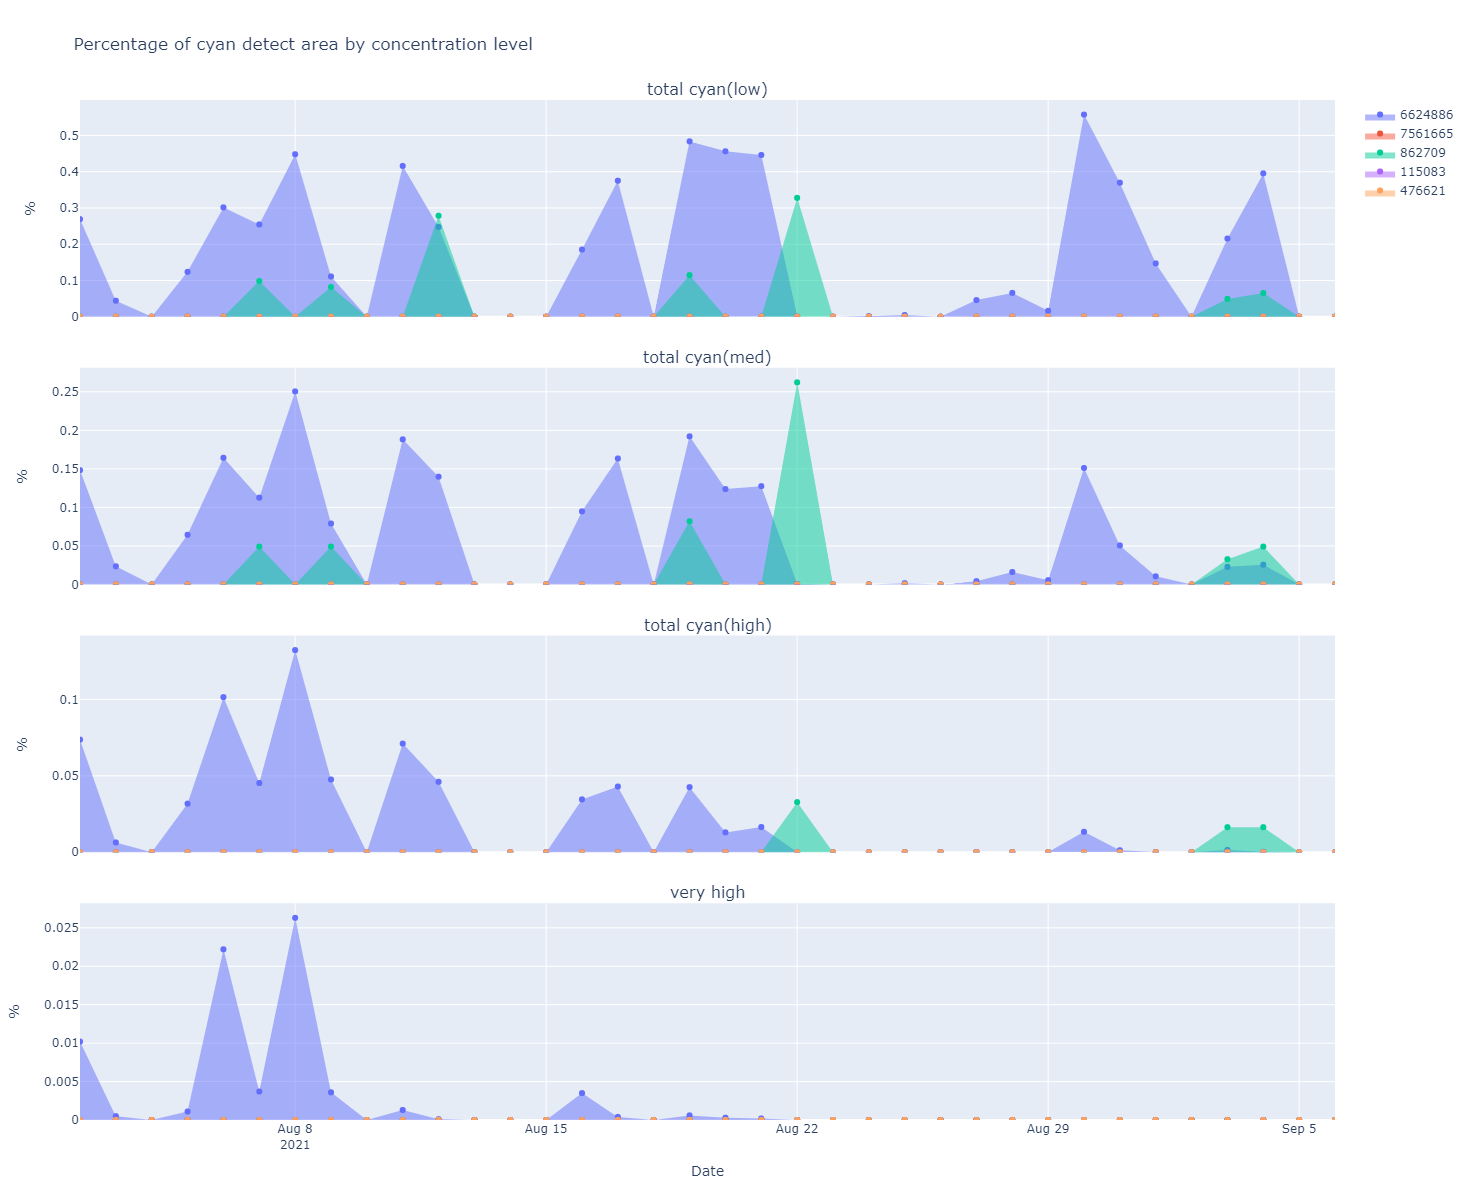

In [39]:
fig = make_subplots(rows=len(totals), cols=1, subplot_titles=totals, shared_xaxes=True, vertical_spacing=0.05)
show_legend = True
for indx, t in enumerate(totals):
    traces2 = []
    target = "total cyan(low)"
    for j, oid in enumerate(objectids):
        j_data = df[df["OBJECTID"] == str(oid)]
        fig.add_trace(go.Scatter(x=j_data["date"], y=j_data[t], name=str(oid), mode='markers', fill='tozeroy', showlegend=show_legend, line_color=px.colors.qualitative.Plotly[j]), row=indx+1, col=1)
        fig.update_yaxes(title_text="%", row=indx+1, col=1)
    show_legend = False
fig.update_xaxes(title_text="Date", row=indx+1, col=1)
fig.update_layout(height=1200, width=1200, title_text="Percentage of cyan detect area by concentration level")
fig.show()

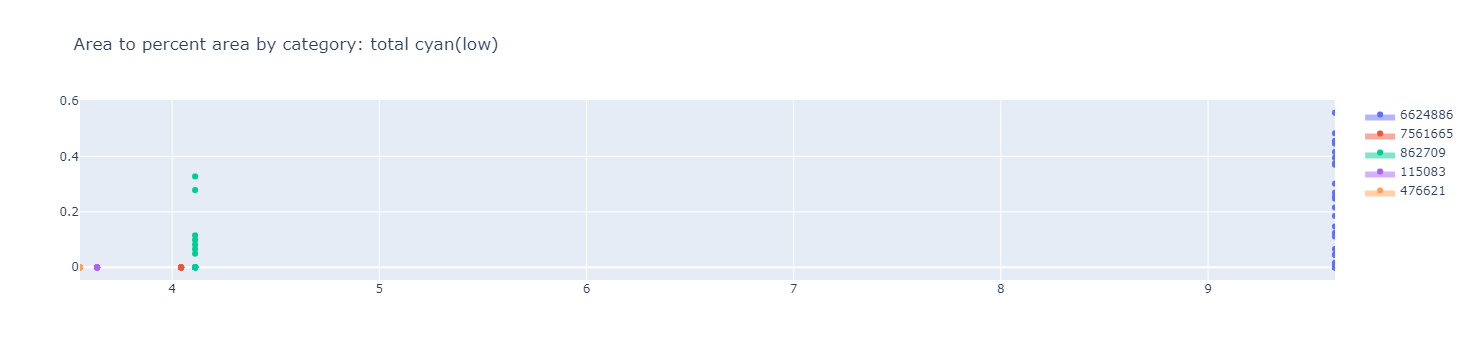

In [42]:
traces2 = []
total_i = 0
for indx, t in enumerate(objectids):
    j_data = df[df["OBJECTID"] == str(t)]
    traces2.append(go.Scatter(x=np.log(j_data["area"]), y=j_data[totals[total_i]], name=t,mode='markers', fill='tozeroy', line_color=px.colors.qualitative.Plotly[indx]))
fig2 = go.Figure(data=traces2)
fig2.update_layout(title={'text':f'Area to percent area by category: {totals[total_i]}'})
fig2.show()

In [20]:
# SIMPLE MEAN IMPUTER

from sklearn.impute import SimpleImputer

s_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
plot_title = "Simple Mean Imputer"
indicator = MissingIndicator(missing_values=np.nan)

totals = ["total cyan(low)", "total cyan(med)", "total cyan(high)", "very high"]

dates = df[["date"]]
objects = df[["OBJECTID"]]
# columns = df.drop("date", axis=1).columns

_df = df.drop(["date"], axis=1)

indicator_values = indicator.fit_transform(_df[totals[:0]])
indicator_values = [1 if any(r) == 1 else 0 for r in indicator_values.astype(int)]

s_imputer.fit(_df[totals][0])
_df[totals[0]] = s_imputer.transform(_df[totals[0]])
_df = pd.DataFrame(_df, columns=totals)
_df["date"] = dates
_df["OBJECTID"] = objects

traces = []
traces.append(go.Bar(name="Imputed Dates", x=i_data["date"], y=indicator_values, marker_color='rgba(231,107,243,0.2)'))
i_data = _df[_df["OBJECTID"] == str(objectids[0])]
for indx, t in enumerate(totals):
    traces.append(go.Scatter(x=i_data["date"], y=i_data[t], name=t, mode='markers', fill='tozeroy', marker_color=list(color_mapping.values())[indx+1]))
fig = go.Figure(data=traces)
fig.update_layout(title={'text':f'{plot_title} for WB: {objectids[oi]}'})
fig.show()

NameError: name 'MissingIndicator' is not defined

In [236]:
# KNN Imputer IMPUTER

from sklearn.impute import KNNImputer, MissingIndicator

knn_imputer = KNNImputer(n_neighbors=10, weights="uniform")
indicator = MissingIndicator(missing_values=np.nan)
dates = df[["date"]]
objects = df[["OBJECTID"]]
columns = df.drop("date", axis=1).columns
_df = df.drop(["date"], axis=1)
indicator_values = indicator.fit_transform(_df)
indicator_values = [1 if any(r) == 1 else 0 for r in indicator_values.astype(int)]

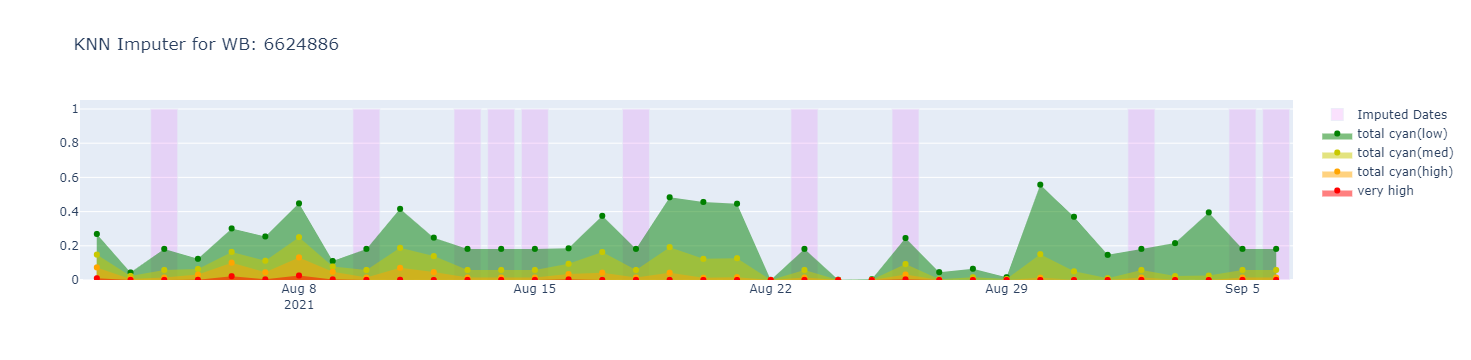

In [237]:
knn_imputer.fit(_df)
_df = knn_imputer.transform(_df)
_df = pd.DataFrame(_df, columns=columns)
_df["date"] = dates

totals = ["total cyan(low)", "total cyan(med)", "total cyan(high)", "very high"]
traces = []
i_data = _df[_df["OBJECTID"] == objectids[0]]
traces.append(go.Bar(name="Imputed Dates", x=i_data["date"], y=indicator_values, marker_color='rgba(231,107,243,0.2)'))
for indx, t in enumerate(totals):
    traces.append(go.Scatter(x=i_data["date"], y=i_data[t], name=t, mode='markers', fill='tozeroy', marker_color=list(color_mapping.values())[indx+1]))
fig3 = go.Figure(data=traces)
fig3.update_layout(title={'text':f'KNN Imputer for WB: {objectids[oi]}'})
fig3.show()

In [238]:
_df

OBJECTID      low   medium     high  very high  total cyan(low)  \
0    6624886.0  0.12080  0.07470  0.06350    0.01020          0.26920   
1    6624886.0  0.02060  0.01720  0.00600    0.00050          0.04420   
2    6624886.0  0.12325  0.04440  0.01377    0.00058          0.18199   
3    6624886.0  0.05940  0.03270  0.03070    0.00110          0.12380   
4    6624886.0  0.13710  0.06290  0.07930    0.02220          0.30160   
..         ...      ...      ...      ...        ...              ...   
175   476621.0  0.11614  0.07525  0.01546    0.00019          0.20703   
176   476621.0  0.11614  0.07525  0.01546    0.00019          0.20703   
177   476621.0  0.11614  0.07525  0.01546    0.00019          0.20703   
178   476621.0  0.11614  0.07525  0.01546    0.00019          0.20703   
179   476621.0  0.11907  0.05163  0.00675    0.00000          0.17747   

     total cyan(med)  total cyan(high)  below detection    land  no data  \
0            0.14840           0.07370              0.0  0.5627   0.0045   
1            0.02360           0.00640              0.0  0.2281   0.0045   
2            0.05874           0.01434              0.0  0.0296   0.0045   
3            0.06450           0.03180              0.0  0.4405   0.0045   
4            0.16440           0.10150              0.0  0.5916   0.0045   
..               ...               ...              ...     ...      ...   
175          0.09090           0.01565              0.0  0.4571   0.0857   
176          0.09090           0.01565              0.0  0.4571   0.0857   
177          0.09090           0.01565              0.0  0.4571   0.0857   
178          0.09090           0.01565              0.0  0.4571   0.0857   
179          0.05839           0.00675              0.0  0.6571   0.0857   

        area       date  
0    14956.0 2021-08-02  
1    14956.0 2021-08-03  
2    14956.0 2021-08-04  
3    14956.0 2021-08-05  
4    14956.0 2021-08-06  
..       ...        ...  
175     35.0 2021-09-02  
176     35.0 2021-09-03  
177     35.0 2021-09-04  
178     35.0 2021-09-05  
179     35.0 2021-09-06  

[180 rows x 13 columns]

OBJECTID       date     low  medium    high  very high  total cyan(low)  \
0    6624886 2021-08-02  0.1208  0.0747  0.0635     0.0102           0.2692   
1    6624886 2021-08-03  0.0206  0.0172  0.0060     0.0005           0.0442   
2    6624886 2021-08-04     NaN     NaN     NaN        NaN              NaN   
3    6624886 2021-08-05  0.0594  0.0327  0.0307     0.0011           0.1238   
4    6624886 2021-08-06  0.1371  0.0629  0.0793     0.0222           0.3016   
..       ...        ...     ...     ...     ...        ...              ...   
175   476621 2021-09-02     NaN     NaN     NaN        NaN              NaN   
176   476621 2021-09-03     NaN     NaN     NaN        NaN              NaN   
177   476621 2021-09-04     NaN     NaN     NaN        NaN              NaN   
178   476621 2021-09-05     NaN     NaN     NaN        NaN              NaN   
179   476621 2021-09-06     NaN     NaN     NaN        NaN              NaN   

     total cyan(med)  total cyan(high)  below detection    land  no data  \
0             0.1484            0.0737              0.0  0.5627   0.0045   
1             0.0236            0.0064              0.0  0.2281   0.0045   
2                NaN               NaN              NaN  0.0296   0.0045   
3             0.0645            0.0318              0.0  0.4405   0.0045   
4             0.1644            0.1015              0.0  0.5916   0.0045   
..               ...               ...              ...     ...      ...   
175              NaN               NaN              NaN  0.4571   0.0857   
176              NaN               NaN              NaN  0.4571   0.0857   
177              NaN               NaN              NaN  0.4571   0.0857   
178              NaN               NaN              NaN  0.4571   0.0857   
179              NaN               NaN              NaN  0.6571   0.0857   

      area  
0    14956  
1    14956  
2    14956  
3    14956  
4    14956  
..     ...  
175     35  
176     35  
177     35  
178     35  
179     35  

[180 rows x 13 columns]

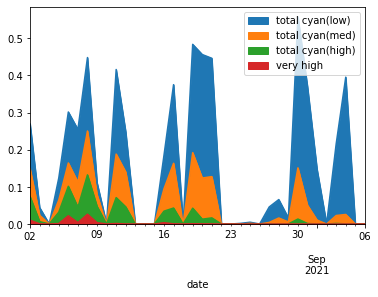

In [85]:
fig, ax = plt.subplots()
oi = 0
totals = ["total cyan(low)", "total cyan(med)", "total cyan(high)", "very high"]
for t in totals:
    df[df["OBJECTID"] == str(objectids[0])].plot(x="date", y=t, kind='area', ax=ax, label=t)
plt.show()

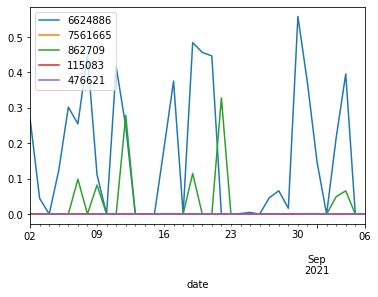

In [82]:
for oid in objectids:
    _df = df[df["OBJECTID"] == str(oid)]
    _df.plot(x="date", y="total cyan", kind='line', ax=ax, label=oid)
plt.show()
# _df = df[df["OBJECTID"] == str(objectids[0])]
# _df["date"]
# _df.plot(x="date"

In [52]:
df0 = df[df["OBJECTID"] == str(objectids[0])]

In [53]:
from sklearn.cluster import KMeans

In [60]:
kmeans_0 = KMeans(n_clusters=4, random_state=42)
id0_data = df0.drop(["date", "OBJECTID"], axis=1)
kmeans_0.fit(id0_data.values)

KMeans(n_clusters=4, random_state=42)

In [61]:
print(kmeans_0.score(id0_data.values))

-0.24697586580086572


In [62]:
results = kmeans_0.predict(id0_data.values)
results

array([3, 1, 2, 1, 3, 3, 3, 1, 2, 0, 3, 2, 2, 2, 3, 3, 2, 0, 0, 0, 3, 2,
       2, 3, 1, 1, 2, 1, 0, 0, 3, 2, 3, 0, 2, 2])

In [63]:
id0_data.values

array([[0.12, 0.07, 0.06, 0.01, 0.  , 0.56, 0.  ],
       [0.02, 0.02, 0.01, 0.  , 0.  , 0.23, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  ],
       [0.06, 0.03, 0.03, 0.  , 0.  , 0.44, 0.  ],
       [0.14, 0.06, 0.08, 0.02, 0.  , 0.59, 0.  ],
       [0.14, 0.07, 0.04, 0.  , 0.  , 0.46, 0.  ],
       [0.2 , 0.12, 0.11, 0.03, 0.  , 0.51, 0.  ],
       [0.03, 0.03, 0.04, 0.  , 0.  , 0.39, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  ],
       [0.23, 0.12, 0.07, 0.  , 0.  , 0.5 , 0.  ],
       [0.11, 0.09, 0.05, 0.  , 0.  , 0.62, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  ],
       [0.09, 0.06, 0.03, 0.  , 0.  , 0.6 , 0.  ],
       [0.21, 0.12, 0.04, 0.  , 0.  , 0.56, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.09, 0.  ],
       [0.29, 0.15, 0.04, 0.  , 0.  , 0.43, 0.  ],
       [0.33, 0.11, 0.01, 0.  , 0.  , 0.53, 0.  ],
       [0.32, 0.11, 0.02, 0.  ,